# Poland 2D Line 001 read and view trace data
Read the first field record from the segy file to a numpy array and visualize the traces.

The first step is to read the file header to get the number of samples in each trace to initialize an empty numpy array in which to store the trace data.

In [11]:
import os
from pathlib import Path
from poland2d_context import segytools

import numpy
import matplotlib.pyplot as plt

TEXTENCODE = 'ebcdic'
ENDIANESS = '>'
TEXTHEADERLENGTH = 3200
FILEHEADERLENGTH = 400
TRCHEADERLENGTH = 240

segyfile = "data/Line_001_NO_AUX_geom.sgy"
pathsegyfile = Path(str(segyfile))
assert (pathsegyfile.is_file())

segyfilesize = os.path.getsize(segyfile)

file_header = segytools.SegyFileHeaderRev2()
trace_header = segytools.SegyTraceHeaderRev2()

# 'rb' is "read bytes"
with open(segyfile, 'rb') as fobj:
    # read the first 3200 bytes.
    # This will always be 3200 byte textual file header
    b_text_header = fobj.read(TEXTHEADERLENGTH)
    last_byte = fobj.tell()

    b_file_header = fobj.read(FILEHEADERLENGTH)
    file_header.set_header_values(buf=b_file_header, endianess=ENDIANESS)
    nsamps = file_header.num_samples_per_trace.value
    print(nsamps)
    print(file_header.data_sample_format_code.mapped_value)
    last_byte = fobj.tell()

    fobj.close()

1501
ibm


Given that the `data_sample_format_code` is ibm, the trace data will be of type `numpy.float32`. Use this information to initialize the trace array for visualization later.

In [12]:
from segytools.toolkit import read_trace_data

traces = numpy.zeros(shape=(nsamps, 1000), dtype=numpy.float32, order='F')  # read up to 1000 traces, each trace is stored in a column, so prefer Fortran ordering

trc_cntr = 0  # trace counter
# 'rb' is "read bytes"
with open(segyfile, 'rb') as fobj:
    # read the first 3200 bytes.
    # This will always be 3200 byte textual file header
    b_text_header = fobj.read(TEXTHEADERLENGTH)
    last_byte = fobj.tell()

    b_file_header = fobj.read(FILEHEADERLENGTH)
    file_header.set_header_values(buf=b_file_header, endianess=ENDIANESS)
    last_byte = fobj.tell()
    
    sample_size_in_bytes = file_header.sample_format_size_in_bytes()
    trc_data_length_in_bytes = file_header.num_samples_per_trace.value * sample_size_in_bytes
    
    # Loop through traces ...
    while trc_cntr < 1000:
        # TRACE HEADER
        b_trace_header = fobj.read(TRCHEADERLENGTH)
        trace_header.set_header_values(buf=b_trace_header, endianess=ENDIANESS)
        if trc_cntr == 0:
            first_field_record = trace_header.field_record_number.value
        if trace_header.field_record_number.value != first_field_record:
            break
        last_byte += TRCHEADERLENGTH

        # TRACE DATA
        if trace_header.num_samples.value != file_header.num_samples_per_trace.value:
            trc_data_length_in_bytes = file_header.num_samples_per_trace.value * sample_size_in_bytes
        b_trace_data = fobj.read(trc_data_length_in_bytes)
        tmp_trace = read_trace_data(buf=b_trace_data, fmt=file_header.sample_format_datatype(), byteorder=ENDIANESS)
        # print(tmp_trace)
        traces[:,trc_cntr] = tmp_trace
        last_byte += trc_data_length_in_bytes

        trc_cntr +=1

    fobj.close()

In [13]:
# visualize the trace data
# reference: https://stackoverflow.com/questions/33651243/plotting-seismic-wiggle-traces-using-matplotlib
print(f'number of traces in first field record: {trc_cntr}')
sample_interval_ms = file_header.sample_interval.value * 0.001  # assumes sample interval in microseconds
print(f'sample interval in milliseconds: {sample_interval_ms}')

number of traces in first field record: 282
sample interval in milliseconds: 2.0


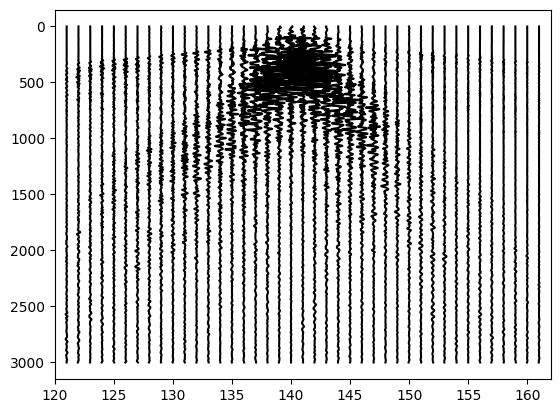

In [14]:
fig,ax = plt.subplots()

twt = [i*int(sample_interval_ms) for i in range(file_header.num_samples_per_trace.value)]

# plot just a few traces around the center of the spread
for j in range(121,162):
    trace = traces[:,j]
    ax.plot(trace+j, twt, 'k-')
    ax.fill_betweenx(twt,j,trace,where=(trace>j),color='k')

ax.set_xlim(120,162)
ax.invert_yaxis()